#IMPORTS



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab.patches import cv2_imshow

import os
import cv2
import tensorflow as tf
import numpy as np 
import math
from math import sqrt
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense


Mounted at /content/drive


#UTILS

In [ ]:
TRAINING_PATH = "/content/drive/MyDrive/database/TRAINING_IMAGES"
TEST_PATH = "/content/drive/MyDrive/database/test_images"

In [ ]:
#PRINT CONFUSION MATRIX
def print_conf_matrix(model, X_test, Y_test, title):
  val_x=Y_test
  pred=model.predict(X_test)
  plt.rcParams["figure.figsize"] = (12,8)

  conf_matrix=confusion_matrix(val_x, pred)
  conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels =test_labels)
  conf_matrix_display.plot()
  plt.title(title)
  plt.xticks(rotation=65,ha='right')
  plt.show()
  print(classification_report(val_x, pred))
  print("\n")

In [ ]:
#PRINT MODEL PREDICTIONS AND METRICS
def model_prediction (model, x_test):
  predictions=model.predict(x_test)
  i=0
  pred=[0,0,0,0,0,0,0,0,0,0,0,0]
  for elem in predictions:
    pred[i]=int(predictions[i])
    i=i+1
  index=0
  for root, dirs, files in os.walk(TEST_PATH):
      for file in files:
          if file.endswith("png") or file.endswith("jpg"):
              path = os.path.join(root, file)
              img=cv2.imread(path)
              cv2_imshow(img)
              print("guess:",  classes_[pred[index]][5:], "  expected:", path[44:])
              index=index+1
              print("\n")

In [ ]:
#CLEAN DATASET
def prepeprocess_data(current_path):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

  for root, dirs, files in os.walk(current_path):
      for file in files:
          if file.endswith("png") or file.endswith("jpg"):
              path = os.path.join(root, file)

              frame = cv2.imread(path)
              faces = face_cascade.detectMultiScale(frame, 1.02, 9)

              if len(faces) != 0:
                  for (x, y, width, height) in faces:
                      roi = frame[y:y+height, x:x+width]
                      roi_res = cv2.resize(roi, (175,175), interpolation=cv2.INTER_AREA)
                    
                      for (x, y, width, height) in faces:
                        eyes = eye_cascade.detectMultiScale(roi[y:(y + height), x:(x + width)], 1.02, 9)
                        index = 0
                        eye_1 = [None, None, None, None]
                        eye_2 = [None, None, None, None]
                        for (ex, ey, ew, eh) in eyes:
                          if index == 0:
                            eye_1 = [ex, ey, ew, eh]
                          elif index == 1:
                            eye_2 = [ex, ey, ew, eh]
                          index = index + 1
                          if (eye_1[0] is not None) and (eye_2[0] is not None):
                            if eye_1[0] < eye_2[0]:
                              left_eye = eye_1
                              right_eye = eye_2
                            else:
                              left_eye = eye_2
                              right_eye = eye_1

                            left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
                            right_eye_center = (int(right_eye[0] + (right_eye[2] / 2)), int(right_eye[1] + (right_eye[3] / 2)))

                            left_eye_x = left_eye_center[0]
                            left_eye_y = left_eye_center[1]
                            right_eye_x = right_eye_center[0]
                            right_eye_y = right_eye_center[1]

                            delta_x = right_eye_x - left_eye_x
                            delta_y = right_eye_y - left_eye_y

                            if delta_x != 0:
                              angle = np.arctan(delta_y / delta_x)

                            # Converting radians to degrees
                            angle = (angle * 180) / np.pi

                            if angle > 3:
                              image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                              rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                              result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                              roi_res=result
                            elif angle < -3:
                              image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                              rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                              result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                              roi_res=result
                            else:
                              image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                              rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                              result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                              roi_res=result

                      for (x, y, width, height) in faces:
                        true_roi = roi_res[y:y+height*3, x:x+width*3]
                        true_roi = cv2.resize(true_roi, (175,175), interpolation=cv2.INTER_AREA)
                      #cv2_imshow(true_roi)
                      cv2.imwrite(path, true_roi)

#prepeprocess_data(TRAINING_PATH)
#prepeprocess_data(TEST_PATH)

#DATA MANIPULATION & FEATURE EXTRACTION

13it [04:28, 20.69s/it]
100%|██████████| 1036/1036 [01:27<00:00, 11.82it/s]


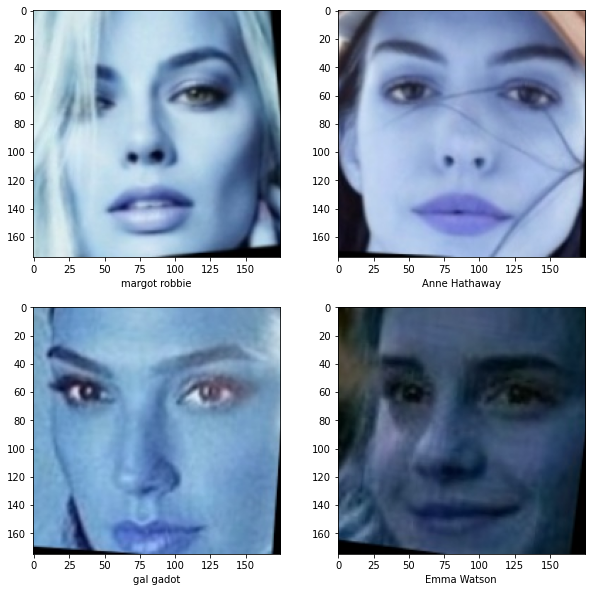

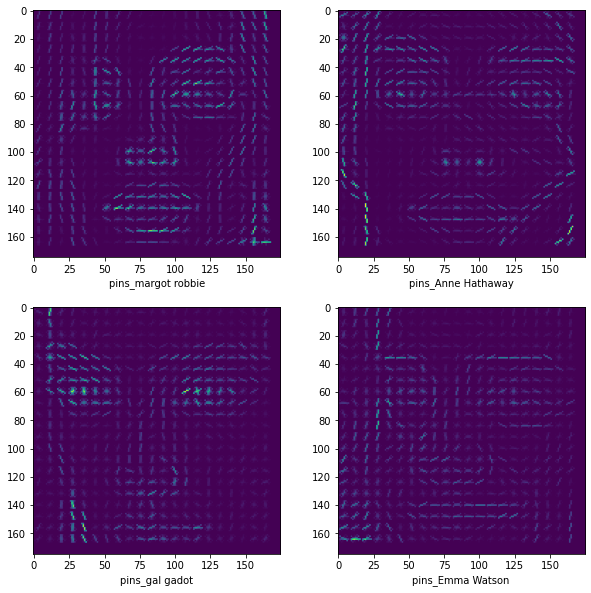

In [ ]:
# TRAIN MANIPULATION
train_data=[]
train_labels=[]

for dirname,_, filenames in tqdm(os.walk(TRAINING_PATH)):
  for filename in filenames:
    image = cv2.imread(os.path.join(dirname, filename))
    
    train_labels.append(dirname.split("/")[-1])
    train_data.append(image)

train_le = LabelEncoder()
train_Labels= train_le.fit_transform(train_labels)
train_Labels = np.array(train_Labels).reshape(len(train_Labels),1)

train_data_gray = [cv2.cvtColor(train_data[i] , cv2.COLOR_BGR2GRAY) for i in range(len(train_data))]

train_hog_features=[]
train_hog_image=[]
for image in tqdm(train_data_gray):
  fd , hogim = hog(image , orientations=9 , pixels_per_cell=(8 , 8) , block_norm='L2' , cells_per_block=(4,4) , visualize=True)
  train_hog_image.append(hogim)
  train_hog_features.append(fd)

randnums= np.random.randint(1,1035,8)
fig = plt.figure(figsize=(10,10))
for i in range(1,5):
  plt.subplot(2,2,i)
  plt.imshow(train_data[randnums[i]])
  plt.xlabel(train_labels[randnums[i]].split("_")[1])
plt.show()

fig = plt.figure(figsize=(10,10))
for i in range(1,5):
  plt.subplot(2,2,i)
  plt.imshow(train_hog_image[randnums[i]])
  plt.xlabel(train_labels[randnums[i]])
plt.show()


train_hog_features = np.array(train_hog_features)
train_df = np.hstack((train_hog_features, train_Labels))

In [ ]:
## TEST MANIPULATION (same as train)
test_data=[]
test_labels=[]

for dirname,_, filenames in tqdm(os.walk(TEST_PATH)):
  for filename in filenames:
    image = cv2.imread(os.path.join(dirname, filename))
    test_data.append(image)

for dirname,_, filenames in tqdm(os.walk(TRAINING_PATH)):
  for filename in filenames:
    if not (dirname.split("/")[-1]) in test_labels:
      test_labels.append(dirname.split("/")[-1])

test_data_gray = [cv2.cvtColor(test_data[i] , cv2.COLOR_BGR2GRAY) for i in range(len(test_data))]

test_hog_features=[]
test_hog_image=[]
for image in tqdm(test_data_gray):
  fd , hogim = hog(image , orientations=9 , pixels_per_cell=(8 , 8) , block_norm='L2' , cells_per_block=(4,4) , visualize=True)
  test_hog_image.append(hogim)
  test_hog_features.append(fd)

test_hog_features = np.array(test_hog_features)

1it [00:03,  3.45s/it]
13it [00:00, 411.27it/s]
100%|██████████| 12/12 [00:00<00:00, 13.30it/s]


In [ ]:
X_train , X_test , Y_train , Y_test = train_test_split(train_df[:,:-1],
                                                       train_df[:,-1], 
                                                       test_size=0.25 , 
                                                       random_state=0 , 
                                                       stratify=train_df[:,-1])

pca = PCA(n_components = 0.90)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

test_hog_features_pca= pca.transform(test_hog_features)

In [ ]:
CNN_TRAINING_PATH = "/content/drive/MyDrive/database/train_cnn"
CNN_VALIDATION_PATH = "/content/drive/MyDrive/database/val_cnn" #about 0.25 of training

img_gen = ImageDataGenerator(rescale = 1/ 255.,  #normalize input
                             brightness_range=[0.8,1.2],
                             rotation_range=8) 

train_gen = img_gen.flow_from_directory(CNN_TRAINING_PATH,
                                       target_size=(175, 175),
                                       batch_size=64, 
                                       class_mode="categorical")

val_gen = img_gen.flow_from_directory(CNN_VALIDATION_PATH, 
                                       target_size=(175, 175),
                                       batch_size=32, 
                                       class_mode="categorical")

classes_ = {v:k for k,v in train_gen.class_indices.items()}
print(classes_)

Found 750 images belonging to 12 classes.
Found 284 images belonging to 12 classes.
{0: 'pins_Andy Samberg', 1: 'pins_Anne Hathaway', 2: 'pins_Chris Evans', 3: 'pins_Emilia Clarke', 4: 'pins_Emma Watson', 5: 'pins_Jason Momoa', 6: 'pins_Jennifer Lawrence', 7: 'pins_Maisie Williams', 8: 'pins_amber heard', 9: 'pins_gal gadot', 10: 'pins_margot robbie', 11: 'pins_scarlett johansson'}


#GRID SEARCH

In [ ]:
def get_hyperparams(params_grid, x_train, y_train, model):
  search = GridSearchCV(model, params_grid, cv = 5, scoring='accuracy')
  result = search.fit(x_train, y_train)
  mean =  result.cv_results_['mean_test_score']
  params = result.cv_results_['params']
  return result

#SVM

Highest mean score with: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
X_test accuracy score->  0.6988416988416989




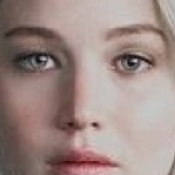

guess: Emilia Clarke   expected: Jennifer Lawrence61_1734.jpg




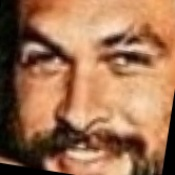

guess: Jason Momoa   expected: Jason Momoa64_2554.jpg




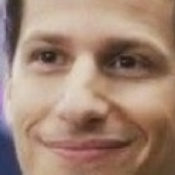

guess: Andy Samberg   expected: Andy Samberg23_541.jpg




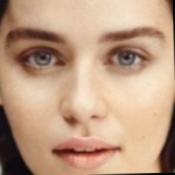

guess: Emilia Clarke   expected: Emilia Clarke143_900.jpg




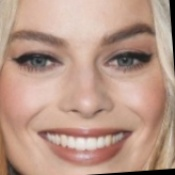

guess: margot robbie   expected: margot robbie94_3274.jpg




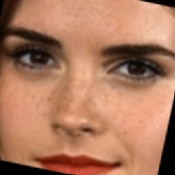

guess: Emma Watson   expected: Emma Watson39_1994.jpg




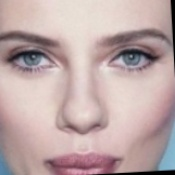

guess: gal gadot   expected: scarlett johansson147_3935.jpg




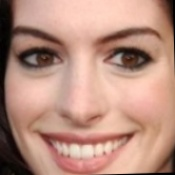

guess: Anne Hathaway   expected: Anne Hathaway32_436.jpg




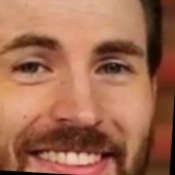

guess: Chris Evans   expected: Chris Evans5_1235.jpg




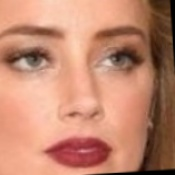

guess: amber heard   expected: amber heard2_309.jpg




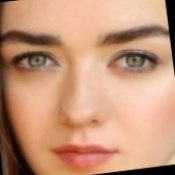

guess: Maisie Williams   expected: Maisie Williams1_2493.jpg




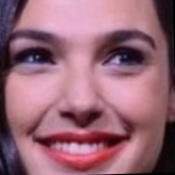

guess: gal gadot   expected: gal gadot97_1854.jpg




In [ ]:
params_grid={
    'kernel':['rbf','linear','sigmoid'],
    'gamma':['scale','auto'],
    'C':[1,100,1000] 
}

svm = SVC(class_weight='balanced')
best_res_svm = get_hyperparams(params_grid, X_train_pca, Y_train, svm)

print("Highest mean score with:", best_res_svm.best_params_)
print("X_test accuracy score-> ", best_res_svm.best_estimator_.score(X_test_pca , Y_test))
print("\n")
model_prediction(best_res_svm, test_hog_features_pca)

#LOGISTIC REGRESSION

highest mean score with: {'penalty': 'l2', 'solver': 'saga'}
X_test accuracy score->  0.7027027027027027




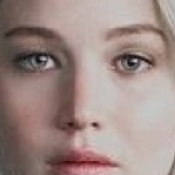

guess: gal gadot   expected: Jennifer Lawrence61_1734.jpg




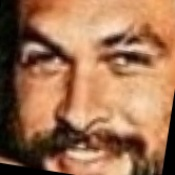

guess: Jason Momoa   expected: Jason Momoa64_2554.jpg




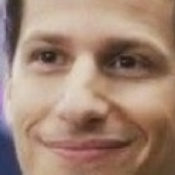

guess: Andy Samberg   expected: Andy Samberg23_541.jpg




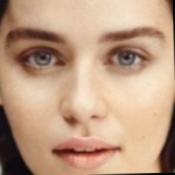

guess: Emilia Clarke   expected: Emilia Clarke143_900.jpg




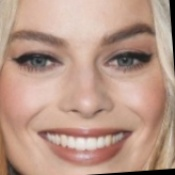

guess: margot robbie   expected: margot robbie94_3274.jpg




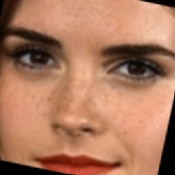

guess: Emma Watson   expected: Emma Watson39_1994.jpg




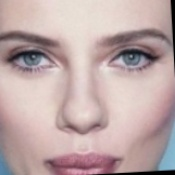

guess: gal gadot   expected: scarlett johansson147_3935.jpg




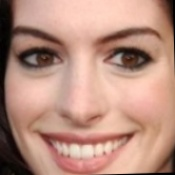

guess: Anne Hathaway   expected: Anne Hathaway32_436.jpg




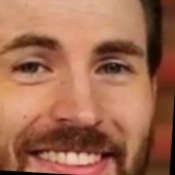

guess: Chris Evans   expected: Chris Evans5_1235.jpg




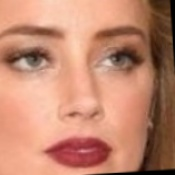

guess: amber heard   expected: amber heard2_309.jpg




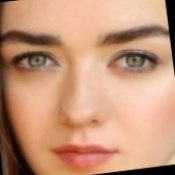

guess: Maisie Williams   expected: Maisie Williams1_2493.jpg




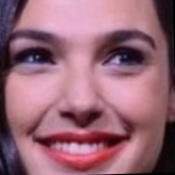

guess: gal gadot   expected: gal gadot97_1854.jpg




In [ ]:
params_grid={
    'penalty':['none','l2'],
    'solver':['lbfgs','saga']
}

lr = LogisticRegression(max_iter=1500)
best_res_lr = get_hyperparams(params_grid, X_train_pca, Y_train, lr)

print("highest mean score with:", best_res_lr.best_params_)
print("X_test accuracy score-> ", best_res_lr.best_estimator_.score(X_test_pca , Y_test))
print("\n")
model_prediction(best_res_lr, test_hog_features_pca)

#RANDOM FOREST

highest mean score with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 500}
X_test accuracy score->  0.5521235521235521




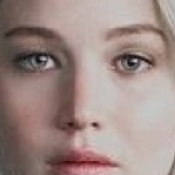

guess: Jennifer Lawrence   expected: Jennifer Lawrence61_1734.jpg




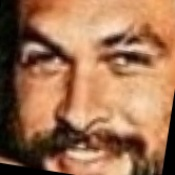

guess: Jason Momoa   expected: Jason Momoa64_2554.jpg




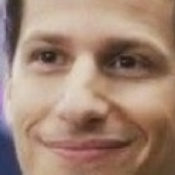

guess: Andy Samberg   expected: Andy Samberg23_541.jpg




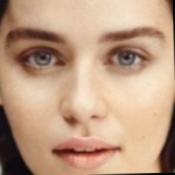

guess: Emilia Clarke   expected: Emilia Clarke143_900.jpg




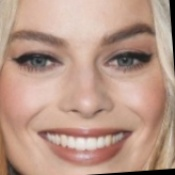

guess: Anne Hathaway   expected: margot robbie94_3274.jpg




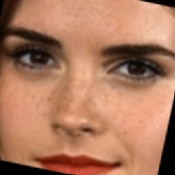

guess: Jennifer Lawrence   expected: Emma Watson39_1994.jpg




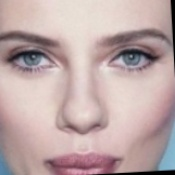

guess: gal gadot   expected: scarlett johansson147_3935.jpg




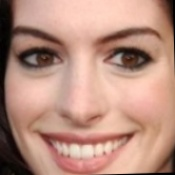

guess: Anne Hathaway   expected: Anne Hathaway32_436.jpg




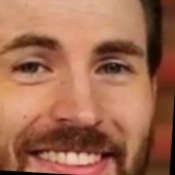

guess: Chris Evans   expected: Chris Evans5_1235.jpg




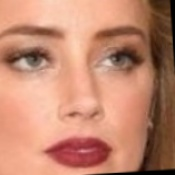

guess: amber heard   expected: amber heard2_309.jpg




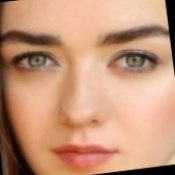

guess: Maisie Williams   expected: Maisie Williams1_2493.jpg




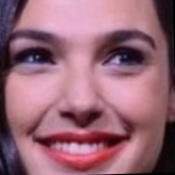

guess: gal gadot   expected: gal gadot97_1854.jpg




In [ ]:
params_grid={
    'n_estimators':[100, 500],
    'criterion':['gini','entropy'],
    'max_features':['sqrt', 'log2'] 
}

rf = RandomForestClassifier(max_depth=15)
best_res_rf = get_hyperparams(params_grid, X_train_pca, Y_train, rf)

print("highest mean score with:", best_res_rf.best_params_)
print("X_test accuracy score-> ", best_res_rf.best_estimator_.score(X_test_pca , Y_test))
print("\n")
model_prediction(best_res_rf, test_hog_features_pca)

#KNN

highest mean score with: {'n_neighbors': 6, 'weights': 'distance'}
X_test accuracy score->  0.555984555984556




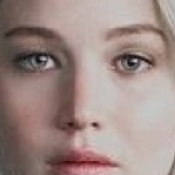

guess: gal gadot   expected: Jennifer Lawrence61_1734.jpg




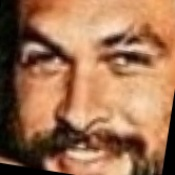

guess: Jason Momoa   expected: Jason Momoa64_2554.jpg




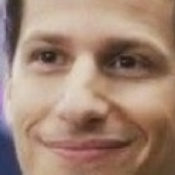

guess: Andy Samberg   expected: Andy Samberg23_541.jpg




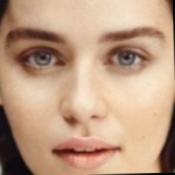

guess: Emilia Clarke   expected: Emilia Clarke143_900.jpg




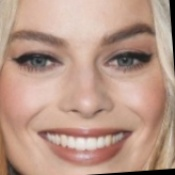

guess: Anne Hathaway   expected: margot robbie94_3274.jpg




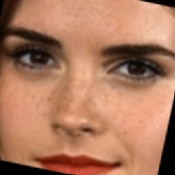

guess: Emma Watson   expected: Emma Watson39_1994.jpg




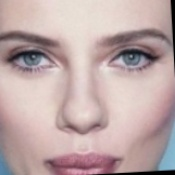

guess: gal gadot   expected: scarlett johansson147_3935.jpg




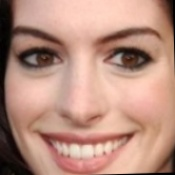

guess: Anne Hathaway   expected: Anne Hathaway32_436.jpg




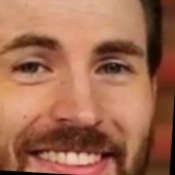

guess: Chris Evans   expected: Chris Evans5_1235.jpg




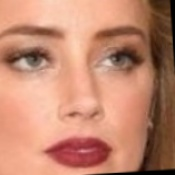

guess: amber heard   expected: amber heard2_309.jpg




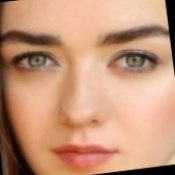

guess: gal gadot   expected: Maisie Williams1_2493.jpg




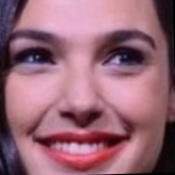

guess: gal gadot   expected: gal gadot97_1854.jpg




In [ ]:
params_grid={
    'n_neighbors':[4, 5, 6],
    'weights':['uniform', 'distance'] 
}

knn = KNeighborsClassifier()
best_res_knn = get_hyperparams(params_grid, X_train_pca, Y_train, knn)

print("highest mean score with:", best_res_knn.best_params_)
print("X_test accuracy score-> ", best_res_knn.best_estimator_.score(X_test_pca , Y_test))
print("\n")
model_prediction(best_res_knn, test_hog_features_pca)

#CONFUSION MATRICES

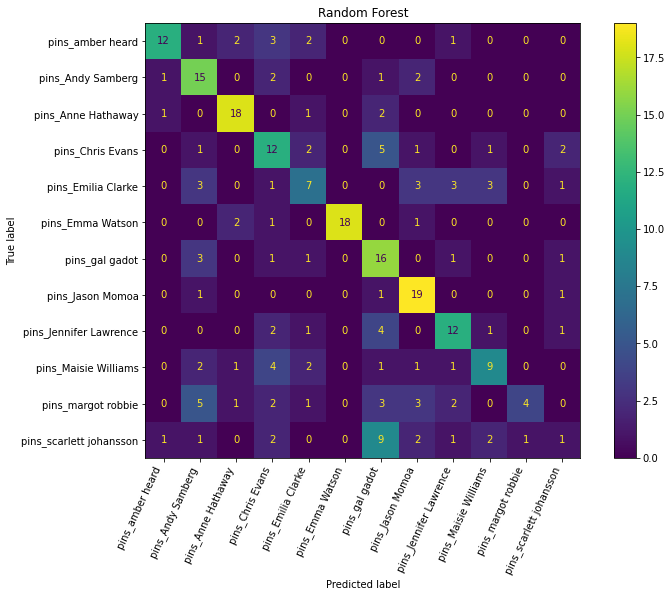

              precision    recall  f1-score   support

         0.0       0.80      0.57      0.67        21
         1.0       0.47      0.71      0.57        21
         2.0       0.75      0.82      0.78        22
         3.0       0.40      0.50      0.44        24
         4.0       0.41      0.33      0.37        21
         5.0       1.00      0.82      0.90        22
         6.0       0.38      0.70      0.49        23
         7.0       0.59      0.86      0.70        22
         8.0       0.57      0.57      0.57        21
         9.0       0.56      0.43      0.49        21
        10.0       0.80      0.19      0.31        21
        11.0       0.14      0.05      0.07        20

    accuracy                           0.55       259
   macro avg       0.57      0.55      0.53       259
weighted avg       0.57      0.55      0.53       259





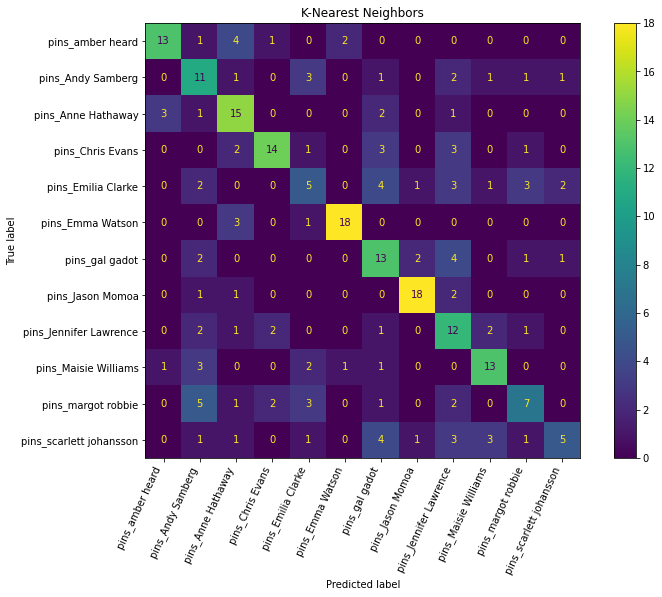

              precision    recall  f1-score   support

         0.0       0.76      0.62      0.68        21
         1.0       0.38      0.52      0.44        21
         2.0       0.52      0.68      0.59        22
         3.0       0.74      0.58      0.65        24
         4.0       0.31      0.24      0.27        21
         5.0       0.86      0.82      0.84        22
         6.0       0.43      0.57      0.49        23
         7.0       0.82      0.82      0.82        22
         8.0       0.38      0.57      0.45        21
         9.0       0.65      0.62      0.63        21
        10.0       0.47      0.33      0.39        21
        11.0       0.56      0.25      0.34        20

    accuracy                           0.56       259
   macro avg       0.57      0.55      0.55       259
weighted avg       0.57      0.56      0.55       259





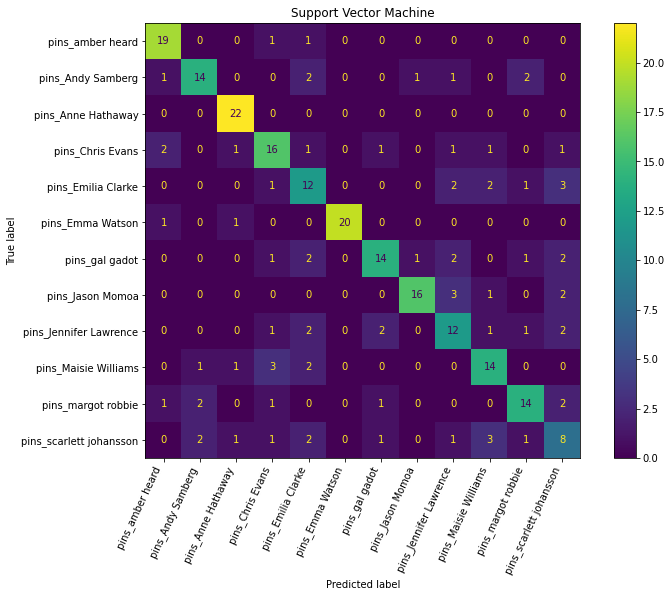

              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84        21
         1.0       0.74      0.67      0.70        21
         2.0       0.85      1.00      0.92        22
         3.0       0.64      0.67      0.65        24
         4.0       0.50      0.57      0.53        21
         5.0       1.00      0.91      0.95        22
         6.0       0.74      0.61      0.67        23
         7.0       0.89      0.73      0.80        22
         8.0       0.55      0.57      0.56        21
         9.0       0.64      0.67      0.65        21
        10.0       0.70      0.67      0.68        21
        11.0       0.40      0.40      0.40        20

    accuracy                           0.70       259
   macro avg       0.70      0.70      0.70       259
weighted avg       0.71      0.70      0.70       259





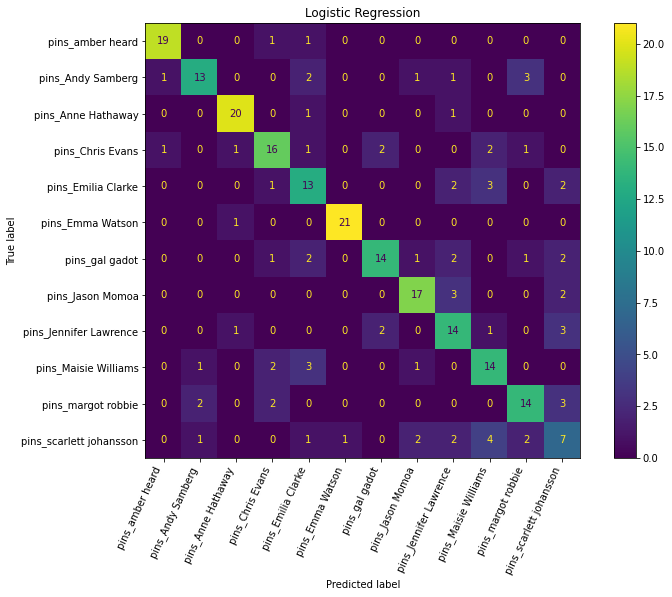

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        21
         1.0       0.76      0.62      0.68        21
         2.0       0.87      0.91      0.89        22
         3.0       0.70      0.67      0.68        24
         4.0       0.54      0.62      0.58        21
         5.0       0.95      0.95      0.95        22
         6.0       0.78      0.61      0.68        23
         7.0       0.77      0.77      0.77        22
         8.0       0.56      0.67      0.61        21
         9.0       0.58      0.67      0.62        21
        10.0       0.67      0.67      0.67        21
        11.0       0.37      0.35      0.36        20

    accuracy                           0.70       259
   macro avg       0.70      0.70      0.70       259
weighted avg       0.71      0.70      0.70       259





In [ ]:
print_conf_matrix(best_res_rf, X_test_pca, Y_test, "Random Forest")
print_conf_matrix(best_res_knn, X_test_pca, Y_test, "K-Nearest Neighbors")
print_conf_matrix(best_res_svm, X_test_pca, Y_test, "Support Vector Machine")
print_conf_matrix(best_res_lr, X_test_pca, Y_test, "Logistic Regression")

# CNN Training

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(175, 175, 3)),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
  
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
  
    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(len(train_gen.class_indices), activation="softmax")    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 175, 175, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 87, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 21, 64)       0

In [ ]:
from keras import metrics

model.compile(optimizer="adam",
             loss=["categorical_crossentropy"],             #Computes the crossentropy loss between the labels and predictions.
             metrics=[metrics.CategoricalAccuracy(),        #Calculates how often predictions match one-hot labels.
                      metrics.Precision(),                  #Computes the precision of the predictions with respect to the labels.
                      metrics.Recall()])                    #Computes the recall of the predictions with respect to the labels.  

#Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=7)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/database/faces.h5", save_best_only=True)

In [ ]:
#history = model.fit(train_gen, validation_data = val_gen, epochs=200, callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
12/12 [==============================] - 48s 4s/step - loss: 2.4952 - categorical_accuracy: 0.0760 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4842 - val_categorical_accuracy: 0.0880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
12/12 [==============================] - 45s 4s/step - loss: 2.4861 - categorical_accuracy: 0.0960 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4843 - val_categorical_accuracy: 0.0880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
12/12 [==============================] - 51s 4s/step - loss: 2.4841 - categorical_accuracy: 0.0920 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4838 - val_categorical_accuracy: 0.0880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
12/12 [==============================] - 44s 4s/step - loss: 2.4850 - categorical_accuracy: 0.0920 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4845 - val_categorical_accuracy: 0.0880 -

val_categorical_accuracy:   0.7711267471313477
val_loss:                   1.1968573331832886
val_precision:              0.8113207817077637
val_recall:                 0.7570422291755676
f1 score:                   0.7832422581996221


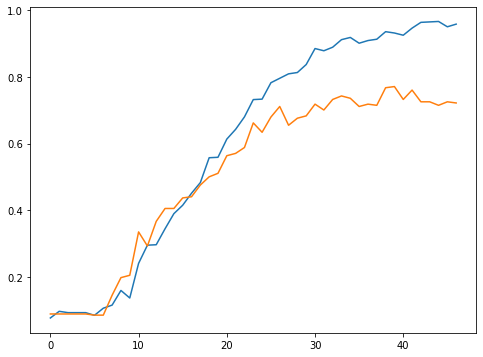

In [ ]:
from keras import backend as K

model = tf.keras.models.load_model("/content/drive/MyDrive/database/faces.h5")

# loss,categorical_acc,precision, recall, auc, categorical_crossentropy = model.evaluate(val_gen)
# print("Restored model, accuracy: {:5.2f}%".format(100 * categorical_acc)) #Epoch 45/200 25s 2s/step - loss: 0.2955 - categorical_accuracy: 0.9067 - val_loss: 1.4690 - val_categorical_accuracy: 0.7113

val_categorical_accuracy=max(history.history["val_categorical_accuracy"])
# ind= history.
val_accs=history.history["val_categorical_accuracy"]
ind=val_accs.index(max(history.history["val_categorical_accuracy"]))


val_loss= history.history["val_loss"][ind]
val_precision= history.history["val_precision"][ind]
val_recall= history.history["val_recall"][ind]

print("val_categorical_accuracy:  ", val_categorical_accuracy)
print("val_loss:                  ", val_loss)
print("val_precision:             ", val_precision)
print("val_recall:                ", val_recall)
print("f1 score:                  ", 2*((val_precision*val_recall)/(val_precision+val_recall)))

fig = plt.figure(figsize=(8,6))
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.show()



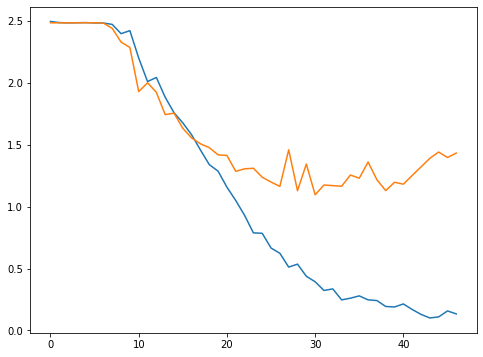

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

# CNN Testing

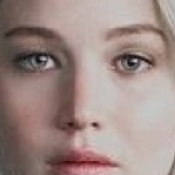

1/1 [==============================] - 0s 119ms/step
guess: Jennifer Lawrence    expected: Jennifer Lawrence61_1734.jpg




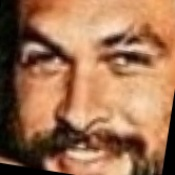

1/1 [==============================] - 0s 36ms/step
guess: Jason Momoa    expected: Jason Momoa64_2554.jpg




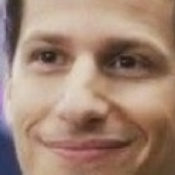

1/1 [==============================] - 0s 34ms/step
guess: Andy Samberg    expected: Andy Samberg23_541.jpg




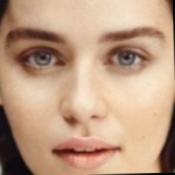

1/1 [==============================] - 0s 36ms/step
guess: gal gadot    expected: Emilia Clarke143_900.jpg




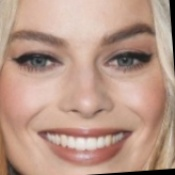

1/1 [==============================] - 0s 39ms/step
guess: Jennifer Lawrence    expected: margot robbie94_3274.jpg




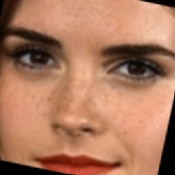

1/1 [==============================] - 0s 34ms/step
guess: Emma Watson    expected: Emma Watson39_1994.jpg




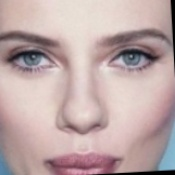

1/1 [==============================] - 0s 32ms/step
guess: Jennifer Lawrence    expected: scarlett johansson147_3935.jpg




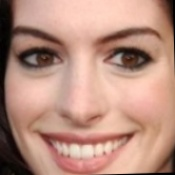

1/1 [==============================] - 0s 31ms/step
guess: Anne Hathaway    expected: Anne Hathaway32_436.jpg




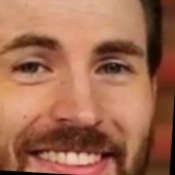

1/1 [==============================] - 0s 35ms/step
guess: Chris Evans    expected: Chris Evans5_1235.jpg




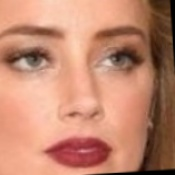

1/1 [==============================] - 0s 38ms/step
guess: amber heard    expected: amber heard2_309.jpg




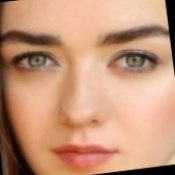

1/1 [==============================] - 0s 33ms/step
guess: Maisie Williams    expected: Maisie Williams1_2493.jpg




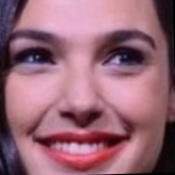

1/1 [==============================] - 0s 38ms/step
guess: Jennifer Lawrence    expected: gal gadot97_1854.jpg




In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/database/faces.h5")
imgs = [i for i in os.listdir("/content/drive/MyDrive/database/test_images") if (i.endswith(".jpg") or i.endswith(".png"))]

newpath="/content/drive/MyDrive/database/test_images"
plt.rcParams["figure.figsize"] = (6,4)

for i in imgs:
  exp=i
  i=os.path.join(newpath, i)
  image=cv2.imread(i)
  cv2_imshow(image)
  img = tf.keras.preprocessing.image.load_img(i, target_size=(175, 175))
  img = tf.keras.preprocessing.image.img_to_array(img) / 255.
  ind = np.argmax(model.predict(img[tf.newaxis, ...]))
  print("guess:", classes_[ind][5:], "  ", "expected:", exp)
  print("\n")
